In [61]:
import sys
print(sys.executable)

/cvmfs/sft.cern.ch/lcg/views/LCG_97apython3/x86_64-centos7-gcc8-opt/bin/python3


In [62]:
from __future__ import division # Force python to turn integer division into a float result! Otherwise your fake rates will be all 0...
%load_ext autoreload
%autoreload 2
import os
import sys
import argparse
import glob
import numpy as np
import uproot
import pandas as pd
import pickle
import tables
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit 
from scipy import integrate
from lmfit import Model, Parameters


plt.rcParams['figure.figsize'] = (10, 7)
plt.rcParams['font.size'] = 14
pd.options.mode.chained_assignment = None  

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
def unzip_files(loc):
    f = uproot.open(loc)
    variables = [var.decode() for var in f["NOMINAL"].keys()] 
    a = f["NOMINAL"].arrays(variables)

    ### New in Python3: decode bytestrings into actual strings, otherwise the strings won't be recognized below
    def convert(data):
        if isinstance(data, bytes):  return data.decode()
        if isinstance(data, dict):   return dict(map(convert, data.items()))
        if isinstance(data, tuple):  return tuple(map(convert, data))
        if isinstance(data, list):   return list(map(convert, data))
        return data
    a = convert(a)

    df = pd.DataFrame.from_dict(a)
    
    for row in tqdm(df.index, total=len(df)):
        
        #pT
        df.at[row,"tau_0_pt"] = df.at[row,"tau_0_p4"].pt
        df.at[row,"tau_1_pt"] = df.at[row,"tau_1_p4"].pt

        #NUTAUANGLE3D-HADRONIC
        df.at[row,"tau_0_p_x"] = df.at[row,"tau_0_p4"].x
        df.at[row,"tau_0_matched_decay_neutrino_p_x"] = df.at[row,"tau_0_matched_decay_neutrino_p4"].x
        df.at[row,"tau_0_p_y"] = df.at[row,"tau_0_p4"].y
        df.at[row,"tau_0_matched_decay_neutrino_p_y"] = df.at[row,"tau_0_matched_decay_neutrino_p4"].y
        df.at[row,"tau_0_p_z"] = df.at[row,"tau_0_p4"].z
        df.at[row,"tau_0_matched_decay_neutrino_p_z"] = df.at[row,"tau_0_matched_decay_neutrino_p4"].z
        df.at[row,"tau_0_p_p"] = df.at[row,"tau_0_p4"].p
        df.at[row,"tau_0_matched_decay_neutrino_p_p"] = df.at[row,"tau_0_matched_decay_neutrino_p4"].p
        df.at[row,"tau_0_matched_decay_neutrino_mass"] = df.at[row,"tau_0_matched_decay_neutrino_p4"].mass

        #NUTAUANGLE3D-LEPTONIC (note: neutrino info is in MeV, while everything else is in GeV)
        df.at[row,"tau_1_p_x"] = df.at[row,"tau_1_p4"].x
        df.at[row,"tau_1_matched_decay_neutrino_p_x"] = df.at[row,"tau_1_matched_leptonic_tau_invis_p4"].x/(10**3)
        df.at[row,"tau_1_p_y"] = df.at[row,"tau_1_p4"].y
        df.at[row,"tau_1_matched_decay_neutrino_p_y"] = df.at[row,"tau_1_matched_leptonic_tau_invis_p4"].y/(10**3)
        df.at[row,"tau_1_p_z"] = df.at[row,"tau_1_p4"].z
        df.at[row,"tau_1_matched_decay_neutrino_p_z"] = df.at[row,"tau_1_matched_leptonic_tau_invis_p4"].z/(10**3)
        df.at[row,"tau_1_p_p"] = df.at[row,"tau_1_p4"].p
        df.at[row,"tau_1_matched_decay_neutrino_p_p"] = df.at[row,"tau_1_matched_leptonic_tau_invis_p4"].p/(10**3)

        #NUTAURATIO-HADRONIC
        df.at[row,"tau_0_p"] = df.at[row,"tau_0_p4"].p #checked
        #trying commented out ones
        #df.at[row,"tau_0_p"] = df.at[row, "tau_0_matched_vis_p4"].p
        df.at[row,"tau_0_matched_decay_neutrino_p"] = df.at[row,"tau_0_matched_decay_neutrino_p4"].p #checked

        #NUTAURATIO-LEPTONIC  
        df.at[row,"tau_1_p_p"] = df.at[row,"tau_1_p4"].p
        df.at[row,"tau_1_matched_decay_neutrino_p"] = df.at[row,"tau_1_matched_leptonic_tau_invis_p4"].p/(10**3)


    #PRESELECTION
    #we want to apply a loose pre-selection, so that we preserve validation and control regions 

    #TAU-RELATED REQUIREMENTS
    # has 1 or 3 prongs - I think that's already encoded somehow 
    # has charge of abosolute value 1 - done, didnt change anything 
    # has pT>20 GeV - changed A LOT when applied to tau_1 (is that where it is meant to go?)
    # not in eta crack region (1.37-1.52)
    # jet RNN trans > 0.01

    df = df[df.tau_0_p_p > 0]
    df = df[df.tau_0_matched_decay_neutrino_p_p > 0]

    df = df[df.tau_1_p_p > 0]
    df = df[df.tau_1_matched_decay_neutrino_p_p > 0]


    df = df[df.tau_0_p > 0]
    df = df[df.tau_0_matched_decay_neutrino_p > 0]

    df = df[df.tau_1_p_p > 0]
    df = df[df.tau_1_matched_decay_neutrino_p > 0]

    df = df[np.abs(df.tau_0_matched_q) ==1.0]

    df = df[df.tau_0_pt > 20.0] #is this fair?, didnt change anyting 
    df = df[df.tau_1_pt > 9.0] #changed a lot, does this also apply to subleading?
    
    return df

In [75]:
df_mc16a_1 = unzip_files("/eos/atlas/atlascerngroupdisk/phys-higgs/HSG4/SM_Htautau_R21/V03/mc/lephad/mc16a/nom/group.phys-higgs.Htt_lh_V03.mc16_13TeV.344772.Sh221_PDF30_Ztt_MV0_70_l13l7.D2.e5585_s3126_r9364_p3978.smPre_w_0_HS/group.phys-higgs.20857127._000001.HSM_common.root")
df_mc16a_2 = unzip_files("/eos/atlas/atlascerngroupdisk/phys-higgs/HSG4/SM_Htautau_R21/V03/mc/lephad/mc16a/nom/group.phys-higgs.Htt_lh_V03.mc16_13TeV.344772.Sh221_PDF30_Ztt_MV0_70_l13l7.D2.e5585_s3126_r9364_p3978.smPre_w_0_HS/group.phys-higgs.20857127._000002.HSM_common.root")
df_mc16a_3 = unzip_files("/eos/atlas/atlascerngroupdisk/phys-higgs/HSG4/SM_Htautau_R21/V03/mc/lephad/mc16a/nom/group.phys-higgs.Htt_lh_V03.mc16_13TeV.344772.Sh221_PDF30_Ztt_MV0_70_l13l7.D2.e5585_s3126_r9364_p3978.smPre_w_0_HS/group.phys-higgs.20857127._000003.HSM_common.root")


#/eos/atlas/atlascerngroupdisk/phys-higgs/HSG4/SM_Htautau_R21/V03/mc/lephad/mc16d/nom/group.phys-higgs.Htt_lh_V03.mc16_13TeV.344772.Sh221_PDF30_Ztt_MV0_70_l13l7.D2.e5585_s3126_r10201_p3978.smPre_w_0_HS/group.phys-higgs.20857311._000001.HSM_common.root
df_mc16d_1 = unzip_files("/eos/atlas/atlascerngroupdisk/phys-higgs/HSG4/SM_Htautau_R21/V03/mc/lephad/mc16d/nom/group.phys-higgs.Htt_lh_V03.mc16_13TeV.344772.Sh221_PDF30_Ztt_MV0_70_l13l7.D2.e5585_s3126_r10201_p3978.smPre_w_0_HS/group.phys-higgs.20857311._000001.HSM_common.root")
df_mc16d_2 = unzip_files("/eos/atlas/atlascerngroupdisk/phys-higgs/HSG4/SM_Htautau_R21/V03/mc/lephad/mc16d/nom/group.phys-higgs.Htt_lh_V03.mc16_13TeV.344772.Sh221_PDF30_Ztt_MV0_70_l13l7.D2.e5585_s3126_r10201_p3978.smPre_w_0_HS/group.phys-higgs.20857311._000002.HSM_common.root")
df_mc16d_3 = unzip_files("/eos/atlas/atlascerngroupdisk/phys-higgs/HSG4/SM_Htautau_R21/V03/mc/lephad/mc16d/nom/group.phys-higgs.Htt_lh_V03.mc16_13TeV.344772.Sh221_PDF30_Ztt_MV0_70_l13l7.D2.e5585_s3126_r10201_p3978.smPre_w_0_HS/group.phys-higgs.20857311._000003.HSM_common.root")
df_mc16d_4 = unzip_files("/eos/atlas/atlascerngroupdisk/phys-higgs/HSG4/SM_Htautau_R21/V03/mc/lephad/mc16d/nom/group.phys-higgs.Htt_lh_V03.mc16_13TeV.344772.Sh221_PDF30_Ztt_MV0_70_l13l7.D2.e5585_s3126_r10201_p3978.smPre_w_0_HS/group.phys-higgs.20857311._000004.HSM_common.root")

#/eos/atlas/atlascerngroupdisk/phys-higgs/HSG4/SM_Htautau_R21/V03/mc/lephad/mc16e/nom/group.phys-higgs.Htt_lh_V03.mc16_13TeV.344772.Sh221_PDF30_Ztt_MV0_70_l13l7.D2.e5585_s3126_r10724_p3978.smPre_w_0_HS/group.phys-higgs.20870675._000001.HSM_common.root
df_mc16e_1 = unzip_files("/eos/atlas/atlascerngroupdisk/phys-higgs/HSG4/SM_Htautau_R21/V03/mc/lephad/mc16e/nom/group.phys-higgs.Htt_lh_V03.mc16_13TeV.344772.Sh221_PDF30_Ztt_MV0_70_l13l7.D2.e5585_s3126_r10724_p3978.smPre_w_0_HS/group.phys-higgs.20870675._000001.HSM_common.root")
df_mc16e_2 = unzip_files("/eos/atlas/atlascerngroupdisk/phys-higgs/HSG4/SM_Htautau_R21/V03/mc/lephad/mc16e/nom/group.phys-higgs.Htt_lh_V03.mc16_13TeV.344772.Sh221_PDF30_Ztt_MV0_70_l13l7.D2.e5585_s3126_r10724_p3978.smPre_w_0_HS/group.phys-higgs.20870675._000002.HSM_common.root")
df_mc16e_3 = unzip_files("/eos/atlas/atlascerngroupdisk/phys-higgs/HSG4/SM_Htautau_R21/V03/mc/lephad/mc16e/nom/group.phys-higgs.Htt_lh_V03.mc16_13TeV.344772.Sh221_PDF30_Ztt_MV0_70_l13l7.D2.e5585_s3126_r10724_p3978.smPre_w_0_HS/group.phys-higgs.20870675._000003.HSM_common.root")

#pd.concat([noclickDF, clickDF], ignore_index=True, sort=True)
df = pd.concat([df_mc16a_1, df_mc16a_2, df_mc16a_3, df_mc16d_1, df_mc16d_2, df_mc16d_3, df_mc16d_4, df_mc16e_1, df_mc16e_2, df_mc16e_3], ignore_index=True, sort=True)



In [76]:
vars = df.keys()
[var for var in vars if "eta" in var]

print(len(df))
#for row in tqdm(df.index, total=len(df)):
    #print(df.at[row,"tau_0_p4"].pt)
    
#df.columns

4118


Text(0.5, 1.0, 'tau_0_decay_mode')

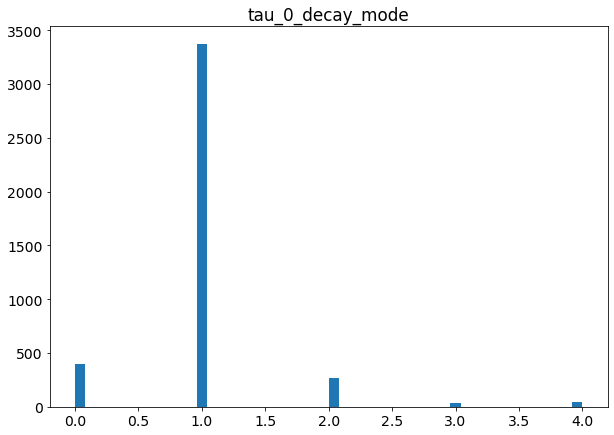

In [77]:
bin_heights, bin_borders, _ = plt.hist(df.tau_0_decay_mode, bins=50, density=False, label='histogram')
plt.title('tau_0_decay_mode')

In [78]:
#self-defined functions
def fit_function(x, p0, p1, p2, p3, p4):
    return (p0 * np.exp(-0.5*((x-p1)/p2)**2) + np.exp(p3 + p4*x)) # gaussian + exponential

def fit_nuTau(x, p0, p1, p2):
    return (p0 * np.exp(-0.5*((x-p1)/p2)*((x-p1)/p2)))

def log_normal(x, p0, p1, p2, p3):
    return (p0 * np.exp(-p2*(np.log((x+p3)/p1))**2)) #lognormal curve - log or log10?

def fit_pT(x, p0, p1, p2, p3):
    return (p0 * np.exp(-p1*np.sqrt(x)) + p2 + p3*x)

In [79]:
michael_had_nuTauRatio = 0.2 #this is placeholder
def calculate_hist(pdf, pdf_name, func, m_params, m_integral, bins, integralCheck=michael_had_nuTauRatio):
    fig, ax = plt.subplots(figsize=(10,8))
    bin_heights, bin_borders, _ = plt.hist(pdf, bins=bins, density=True, label='histogram')
    bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
    print("bin width: " + str(np.diff(bin_borders)[0]))
    michael_integral, error = integrate.quad(integralCheck, a=bins[0], b=bins[-1])
    print('michael integral): ' + str(michael_integral))
    
    popt, _ = curve_fit(func, bin_centers, bin_heights, maxfev=1000000, p0=m_params)
    x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 1000)
    
    #uncomment the line below if you want to directly calculate the integral (and make sure to make a function callable)
    #ax.plot(x_interval_for_fit, (1/michael_integral)*func(x_interval_for_fit, *m_params), label='michael')
    ax.plot(x_interval_for_fit, (1/m_integral)*func(x_interval_for_fit, *m_params), label='michael')
    ax.plot(x_interval_for_fit, func(x_interval_for_fit, *popt), linewidth=2, label='fit')
    ax.set_xlabel(pdf_name,fontsize=30)

    ax.tick_params(labelsize=16)
    ax.legend(fontsize=16)
    
    #uncomment to save fig
    #plt.savefig('/Users/ibhallaladd/Desktop/'+ pdf_name + '_test.root')

    print("Michael's Params | " + str(m_params))
    print("My Params        | " + str(popt))
    #return popt
    
#this is the main method for fitting the histogram (without michael) and PT dependent 
def calculate_hist_pT(pdf, pdf_name, func, bins):
    fig, ax = plt.subplots(figsize=(10,8))
    bin_heights, bin_borders, _ = plt.hist(pdf, bins=bins, density=True, label='histogram')

    bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2     
    #uncomment if you want to go back to scipy's curvefit
    popt, pcov = curve_fit(func, bin_centers, bin_heights, maxfev=1000000)

    x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 1000)
    
    #uncomment the line below if you want to directly calculate the integral (and make sure to make a function callable)
    #ax.plot(x_interval_for_fit, (1/michael_integral)*func(x_interval_for_fit, *m_params), label='michael')
    #ax.plot(x_interval_for_fit, (1/m_integral)*func(x_interval_for_fit, *m_params), label='michael')

    ax.plot(x_interval_for_fit, func(x_interval_for_fit, *popt), linewidth=2, label='fit: ' +str(popt))
   
    #ax.plot(x_interval_for_fit, result.values, linewidth=2, label='fit: ' +str(popt))
    ax.set_xlabel(pdf_name,fontsize=30)

    ax.tick_params(labelsize=16)
    #print("My Params        | " + str(popt))
    
    return popt


In [80]:
def find_slices(hist, pT, desired_bins):
    threshold = np.ceil(len(hist)/desired_bins) #how many events in each pT bin
    print(threshold)
    previous = 0
    ranges = [[0,0]]
    
    #step through ordered pT, and add a cut when you reach the threshold, then reset
    for vals in np.sort(pT):
        eggs = len(hist[(pT>previous)&(pT<vals)]) #how many eggs in the basket?
        if (eggs == threshold) or (vals == np.sort(pT)[len(pT)-1]): #control for last bin
            ranges.append([previous, vals])#this is your pT cut 
            previous = vals
    ranges.pop(0)
    return ranges  

nuTauAngle_had = np.arccos(((df.tau_0_p_x*df.tau_0_matched_decay_neutrino_p_x)+(df.tau_0_p_y*df.tau_0_matched_decay_neutrino_p_y)+
                        (df.tau_0_p_z*df.tau_0_matched_decay_neutrino_p_z))/
                           (df.tau_0_p_p*df.tau_0_matched_decay_neutrino_p_p))
print(len(nuTauAngle_had[(df.tau_0_n_charged_tracks==1)&(df.tau_0_matched_n_neutral_pion==0)]))
test_ranges = find_slices(nuTauAngle_had, df.tau_0_pt, 4)
print(test_ranges)

4035
1030.0
[[0, 32.61930859375], [32.61930859375, 36.23875390625], [36.23875390625, 42.52134765625], [42.52134765625, 83.9273671875]]


In [81]:
def dmode_pdfs(numSlices, dmode):
    
    prongN = 0
    nupionN = 0
        
    nuTauAngle_dmode = np.arccos(((df.tau_0_p_x*df.tau_0_matched_decay_neutrino_p_x)+(df.tau_0_p_y*df.tau_0_matched_decay_neutrino_p_y)+
                                (df.tau_0_p_z*df.tau_0_matched_decay_neutrino_p_z))/
                                   (df.tau_0_p_p*df.tau_0_matched_decay_neutrino_p_p))[df.tau_0_decay_mode==dmode]

    cuts = find_slices(nuTauAngle_dmode, df.tau_0_pt, numSlices)

    weighted_pT_cuts = np.zeros(len(cuts))
    i = 0

    for elem in cuts: 
        weighted_pT_cuts[i] = np.mean(df.tau_0_pt[(df.tau_0_pt>(elem[0]))&(df.tau_0_pt<(elem[1]))])
        i = i + 1
    
    print('weighted_pT_cuts' + str(weighted_pT_cuts))

    par0 = np.zeros(len(cuts))
    par1 = np.zeros(len(cuts))
    par2 = np.zeros(len(cuts))
    par3 = np.zeros(len(cuts))

    count = 0
    for slice in cuts:
        
        nuTauAngle_had_pT = nuTauAngle_dmode[(df.tau_0_pt>(cuts[count][0]))&(df.tau_0_pt<(cuts[count][1]))]
        params = calculate_hist_pT(nuTauAngle_had_pT,"hadronic nuTauAngle3d_pT" + str(count)+" [radians]", log_normal, bins=np.linspace(0,0.35,30))

        par0[count] = params[0]
        par1[count] = params[1]
        par2[count] = params[2]
        par3[count] = params[3]
        count = count + 1

        #labels are Michael's key

    x_interval = np.linspace(0, 200, 1000)
    fig, (ax0, ax1, ax2, ax3) = plt.subplots(4, figsize=(14,12))
    fig.tight_layout(pad=3.0)

    #ax0.errorbar(interpolated_cuts, par0, xerr=interpolated_cuts_err)
    ax0.scatter(weighted_pT_cuts, par0)
    popt0, _ = curve_fit(fit_pT, weighted_pT_cuts, par0, maxfev=10000000)
    #ax0.plot(x_interval, fit_pT(x_interval, *popt0))
    ax0.set_xlabel('pT vs. p0 (your p0)')


    ax3.scatter(weighted_pT_cuts, par3)
    popt3, _ = curve_fit(fit_pT, weighted_pT_cuts, par3, maxfev=1000000)
    #ax3.plot(x_interval, fit_pT(x_interval, *popt3))
    ax3.set_xlabel('pT vs. p1 (your p3)')
    ax3.set_ylim(-100,120)

    ax1.scatter(weighted_pT_cuts, par1)
    popt1, _ = curve_fit(fit_pT, weighted_pT_cuts, par1, maxfev=1000000)
    #ax1.plot(x_interval, fit_pT(x_interval, *popt1))
    ax1.set_xlabel('pT vs. p2 (your p1)')

    ax2.scatter(weighted_pT_cuts, par2)
    popt2, _ = curve_fit(fit_pT, weighted_pT_cuts, par2, maxfev=1000000)
    #ax2.plot(x_interval, fit_pT(x_interval, *popt2))
    ax2.set_xlabel('pT vs. p3 (your p2)')
    ax2.set_ylim(-100,120)
    #ax2.set_ylim(-10,100)

    return weighted_pT_cuts, par0, par1, par2, par3


In [82]:
def dmode_pdfs_noSlice(dmode):
        
    nuTauAngle_dmode = np.arccos(((df.tau_0_p_x*df.tau_0_matched_decay_neutrino_p_x)+(df.tau_0_p_y*df.tau_0_matched_decay_neutrino_p_y)+
                                (df.tau_0_p_z*df.tau_0_matched_decay_neutrino_p_z))/
                                   (df.tau_0_p_p*df.tau_0_matched_decay_neutrino_p_p))[df.tau_0_decay_mode==dmode]
    print('fraction of elements: '+ str(100*(len(nuTauAngle_dmode)/len(df.tau_0_p_x))))

    x_interval = np.linspace(0, 200, 1000)
    fig, ax0 = plt.subplots(figsize=(10,8))
    fig.tight_layout(pad=3.0)

    bin_heights, bin_borders, _ = plt.hist(nuTauAngle_dmode, bins=40, density=False, label='histogram')
    ax0.set_xlabel(str(dmode)+ ' hadronic nuTauAngle3d')

fraction of elements: 9.713453132588636


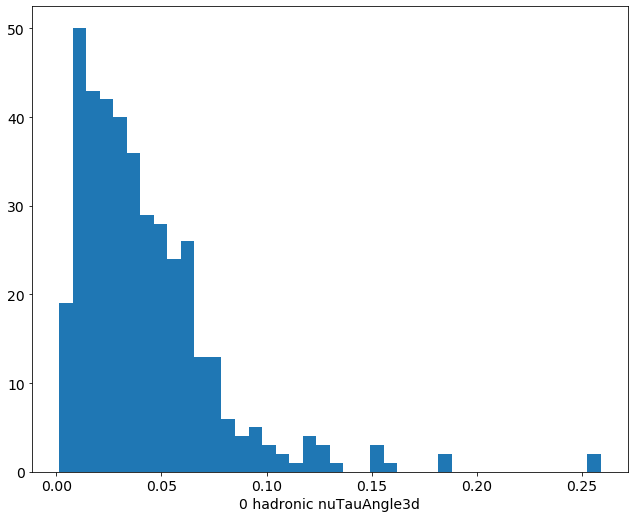

In [83]:
dmode_pdfs_noSlice(0)

421.0
weighted_pT_cuts[30.52198453 31.83608257 33.34972598 35.12838876 37.51135896 40.70682844
 44.87577629 54.74451663]


/usr/local/bin/start_ipykernel.py:9: RuntimeWarning: invalid value encountered in log
/usr/local/bin/start_ipykernel.py:12: RuntimeWarning: overflow encountered in exp


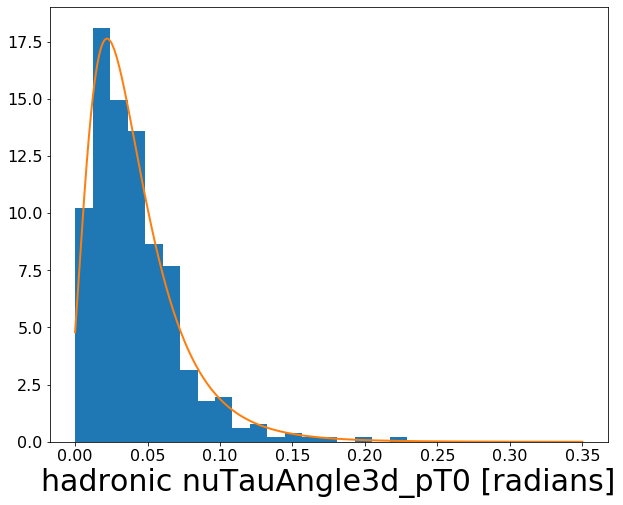

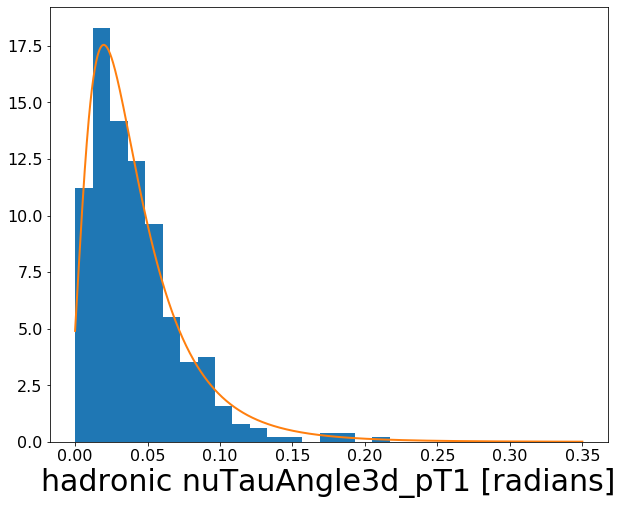

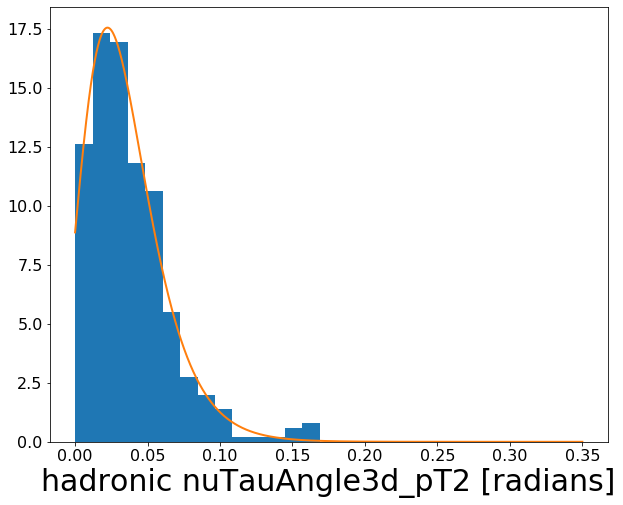

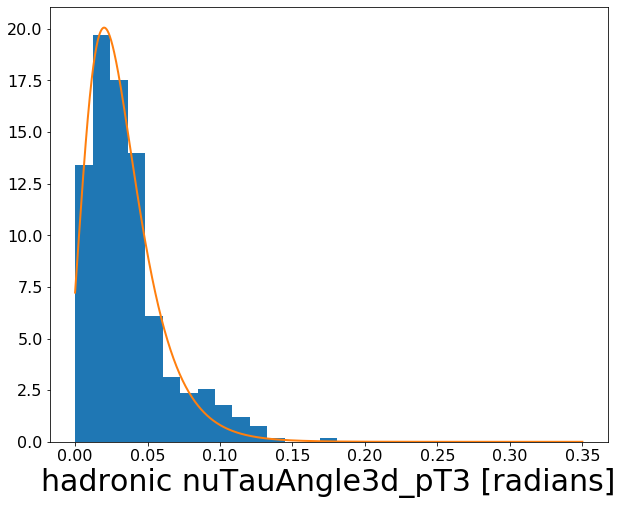

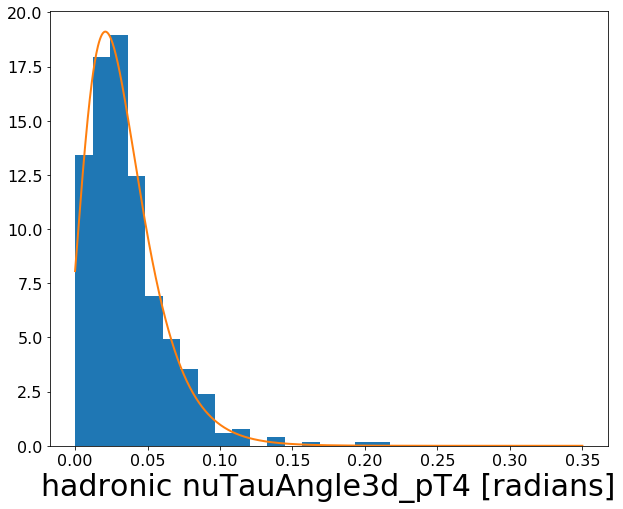

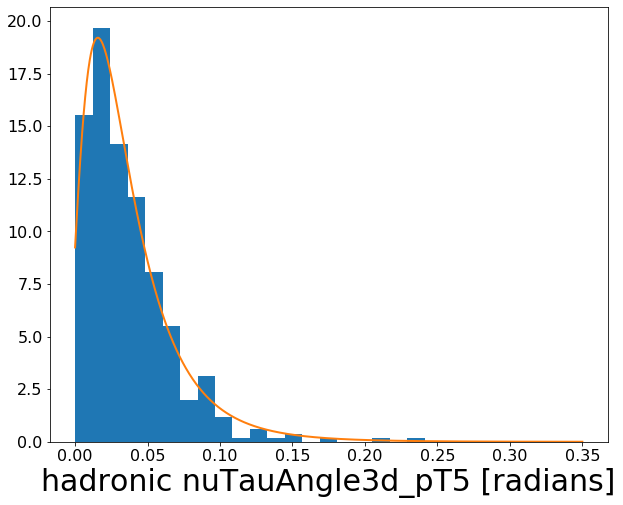

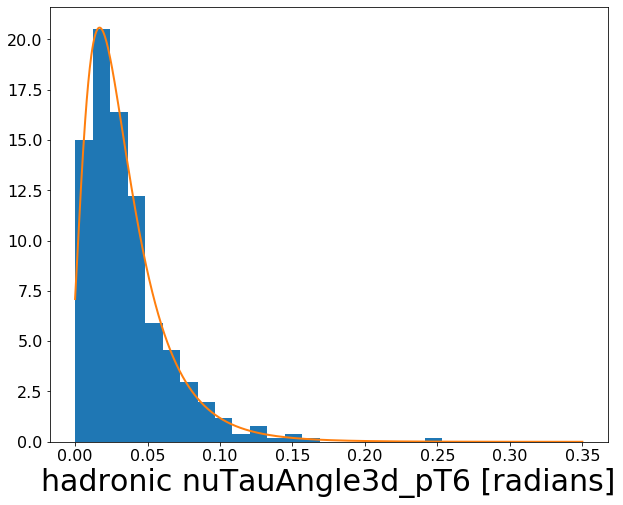

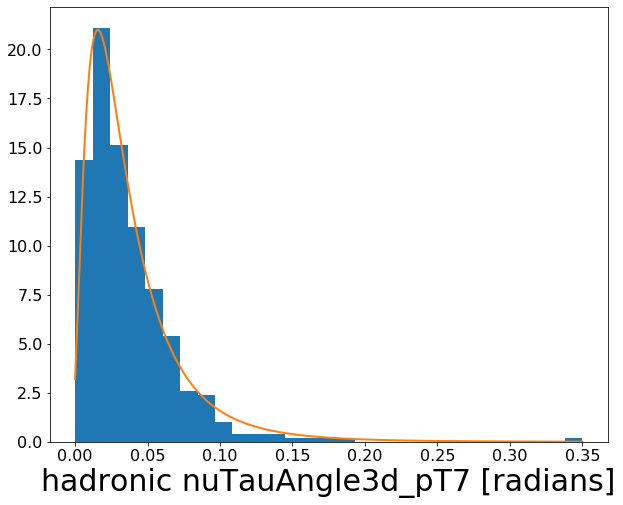

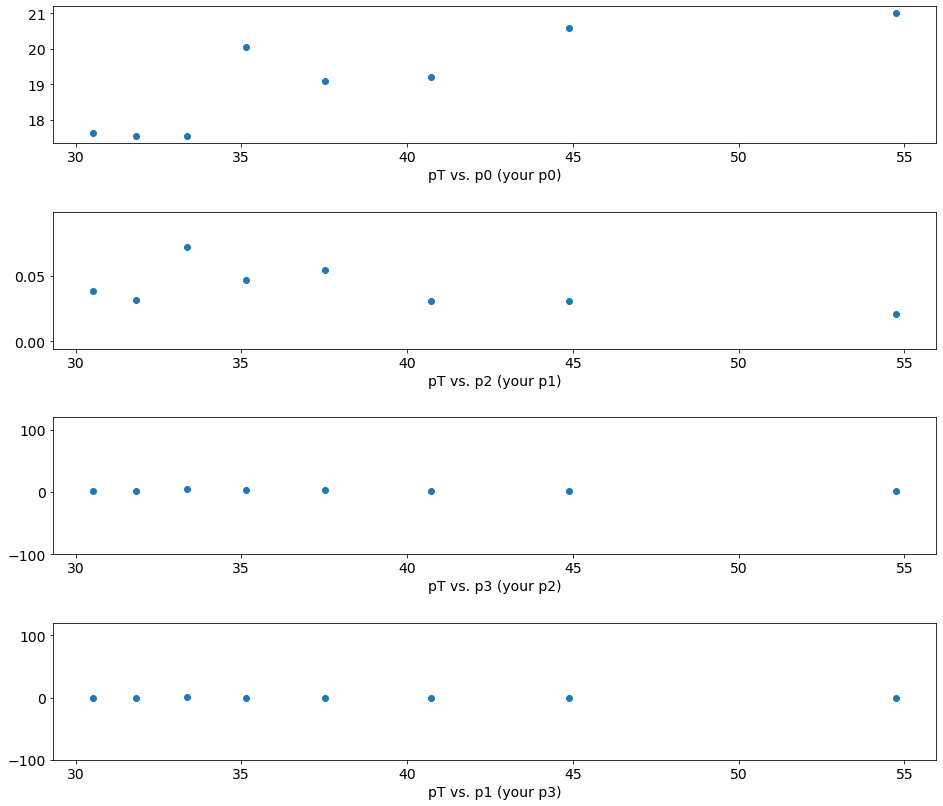

In [84]:
weighted_pT_cuts, par0, par1, par2, par3 = dmode_pdfs(8, 1)

Text(0.5, 0, 'pT vs. params p3')

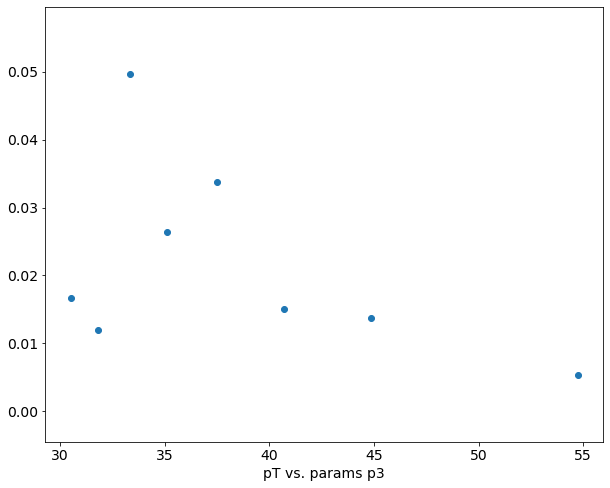

In [90]:
x_interval = np.linspace(0, 100, 1000)
fig, ax3 = plt.subplots(figsize=(10,8))
ax3.scatter(weighted_pT_cuts, par3)
#popt0, _ = curve_fit(fit_pT, weighted_pT_cuts, par0, maxfev=1000000)
#ax3.plot(x_interval, fit_pT(x_interval, *popt0))
ax3.set_xlabel('pT vs. params p3')
#ax3.set_xlim(0,200)
